# Does having an unlimited dimension affect NetCDF throughput?

tl;dr Throughput is about 2x better with limited dimensions. Number of variables has no effect. See below for details.

In [1]:
import sys
import os
from tempfile import NamedTemporaryFile
from gc import collect

sys.path.append('../util')
from meters import ThroughputMeter, clear_host_cache
import ncgen
from grids import timescales

import netCDF4
import numpy as np
import pylab as pl

# NOTE: ensure that this directory is set to an HDD!
# Otherwise the entire experiment isn't representative
tmpdir = '../tmp'

In [2]:
results = []
for timescale in (timescales['seasonal'], range(50)):
    for unlim in [True, False]:
        for num_vars in range(1, 20, 2):
            print("Creating a NetCDF file with {} {}limited variables and {} timesteps".format(num_vars, 'un' if unlim else '', len(timescale)))
            with NamedTemporaryFile(suffix='.nc', delete=False, dir=tmpdir) as f:
                nc = ncgen.make_nc(f.name, num_vars=num_vars, unlim=unlim, timescale=timescale)
                nc.close()
            clear_host_cache()
            nc = netCDF4.Dataset(f.name, 'r')
            with ThroughputMeter() as t:
                a = nc.variables['var_0'][:, :, :]
        
            # python-netCDF4 seems to leak file descriptors
            # We have to take a lot of steps to make sure that the files get closed and that
            # the space gets reclaimed by the OS
            nc.close
            del nc
            print("Removing {}".format(f.name))
            os.remove(f.name)
            f.close()
            collect()
            results.append((unlim, num_vars, t.megabytes_per_second(a)))


Creating a NetCDF file with 1 unlimited variables and 17 timesteps
host cache cleared
Removing /app/tmp/tmpffa7juw_.nc
353.100 MB in 0.245 seconds at 1438.813 MB / sec
Creating a NetCDF file with 3 unlimited variables and 17 timesteps
host cache cleared
Removing /app/tmp/tmp9fp10mn6.nc
353.100 MB in 9.49 seconds at 37.191 MB / sec
Creating a NetCDF file with 5 unlimited variables and 17 timesteps
host cache cleared
Removing /app/tmp/tmphb5heldt.nc
353.100 MB in 11.9 seconds at 29.557 MB / sec
Creating a NetCDF file with 7 unlimited variables and 17 timesteps
host cache cleared
Removing /app/tmp/tmpldept0o7.nc
353.100 MB in 12.2 seconds at 28.984 MB / sec
Creating a NetCDF file with 9 unlimited variables and 17 timesteps
host cache cleared
Removing /app/tmp/tmpujzb86o5.nc
353.100 MB in 11.7 seconds at 30.252 MB / sec
Creating a NetCDF file with 11 unlimited variables and 17 timesteps
host cache cleared
Removing /app/tmp/tmp3f3c74e0.nc
353.100 MB in 12.0 seconds at 29.303 MB / sec
Creati

In [3]:
results

[(True, 1, 1438.8127376555144),
 (True, 3, 37.19105144054339),
 (True, 5, 29.557286536431508),
 (True, 7, 28.983589322780567),
 (True, 9, 30.251789437561566),
 (True, 11, 29.303047204976071),
 (True, 13, 26.411985767345339),
 (True, 15, 28.361491980181679),
 (True, 17, 28.226718852356488),
 (True, 19, 28.31762426829372),
 (False, 1, 1876.8215089519251),
 (False, 3, 1701.818282102844),
 (False, 5, 47.507986258102584),
 (False, 7, 50.466559834385997),
 (False, 9, 50.88194917368606),
 (False, 11, 45.757900938251673),
 (False, 13, 47.569278480092983),
 (False, 15, 47.197479839191558),
 (False, 17, 49.619092769150413),
 (False, 19, 30.882685746858488),
 (True, 1, 38.418601871461085),
 (True, 3, 23.447973699449609),
 (True, 5, 24.846703980134976),
 (True, 7, 24.484092335751484),
 (True, 9, 20.726455039440754),
 (True, 11, 22.311011007791677),
 (True, 13, 22.3324301009525),
 (True, 15, 20.349171353062808),
 (True, 17, 20.568721049630803),
 (True, 19, 28.08668546865389),
 (False, 1, 28.4036568

In [4]:
a = np.array([result[2] for result in results])
a = a.reshape(2, 2, 10)
a

array([[[ 1438.81273766,    37.19105144,    29.55728654,    28.98358932,
            30.25178944,    29.3030472 ,    26.41198577,    28.36149198,
            28.22671885,    28.31762427],
        [ 1876.82150895,  1701.8182821 ,    47.50798626,    50.46655983,
            50.88194917,    45.75790094,    47.56927848,    47.19747984,
            49.61909277,    30.88268575]],

       [[   38.41860187,    23.4479737 ,    24.84670398,    24.48409234,
            20.72645504,    22.31101101,    22.3324301 ,    20.34917135,
            20.56872105,    28.08668547],
        [   28.40365681,    39.97474157,    41.10097522,    43.5120609 ,
            43.43780595,    45.8517866 ,    48.19800229,    41.50530757,
            41.85452212,    39.83284359]]])

In [7]:
%matplotlib inline

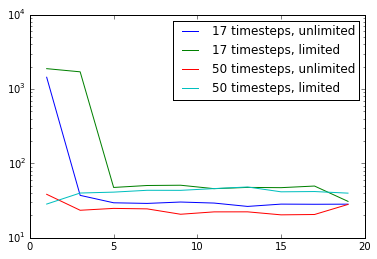

In [9]:
fig = pl.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(range(1, 20, 2), a[0,0,:], label='17 timesteps, unlimited')
ax.plot(range(1, 20, 2), a[0,1,:], label='17 timesteps, limited')
ax.plot(range(1, 20, 2), a[1,0,:], label='50 timesteps, unlimited')
ax.plot(range(1, 20, 2), a[1,1,:], label='50 timesteps, limited')
ax.set_yscale("log")
ax.legend()

In [11]:
353.100 * np.arange(4, 6)

array([ 1412.4,  1765.5])

In [12]:
!free -m

             total       used       free     shared    buffers     cached
Mem:          7945       5939       2005         43        347       1981
-/+ buffers/cache:       3610       4334
Swap:        47685        861      46823


On this run I had about 2005 MB free on the system, so it's plausible that 4+ variables at 3000+ MB pushes me out of cache on to disk. That explains the jump.

So this experiment shows that there *is* a distinguishable difference between unlimited and limited dimensions. However, we do *not* see a decrease proportional to the number of variables. It looks like it's about a factor of 2 across the board. Which is good, and worth making dimensions limited, but it's not *awful* to use unlimited dimensions with a high number of variables.

In [13]:
!hostname

2a1de1d68d90
